In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from casting.configuration import paths, columns, params
from casting.preprocessing import (
                                   drop_null, 
                                   split_by_dbscan,
                                   remove_outlier,
                                   save_scaler,
                                   save_label_encoding)
from casting.utils import load_data


from casting.trainner import train_xgboost, train_lightgbm, train_extra_trees, train_tabnet, train_FTT, FttDataloader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


from torch.utils.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pandas as pd
pd.set_option('display.max_columns', None) ## 모든 열을 출력한다
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_manager.fontManager.addfont('NanumGothic-Bold.ttf')
plt.rc('font', family='NanumGothic')

cpu


In [2]:
data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')
data = data_origin[columns.use_columns]

# Preprocessing

### base

In [3]:
## null 값 제외
data = drop_null(data).reset_index(drop=True)
## 이상치 제거
data = remove_outlier(data)


if params.model_name == 'FTT':
    ## 스케일러 생성
    save_scaler(data, 
                columns.numeric_columns, 
                columns.target_column,
                paths.X_scaler_path,
                paths.y_scaler_path
                )
    ## 카테고리 컬럼 처리를 위한 라벨 인코딩
    save_label_encoding(data, columns.category_columns, paths.label_encoding_path)

    split_by_dbscan(data, 'casting/data/scaled_data/')
else :
    ## 데이터 분리
    split_by_dbscan(data, 'casting/data/processed_data/')

# Predictor

### load_data

In [4]:
train, valid, test = load_data(params.model_name)

### Modeling

In [5]:
## TODO : 모듈 형식으로 모델 GATEWAY 함수 구성
## TODO : AUTO ML 넣어서 제일 좋은 성능을 Select하는 형식

if params.model_name == 'LGBM' :
    model = train_lightgbm(train, valid)
elif params.model_name == 'XGB' :
    model = train_xgboost(train, valid)
elif params.model_name == 'EXT' :
    model = train_extra_trees(train, valid)
elif params.model_name == 'TABNET' :
    model = train_tabnet(train, valid)
## GPU 환경 필수
elif params.model_name == 'FTT' :
    model = train_FTT(train, valid)

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Number of positive: 2586, number of negative: 59825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 62411, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041435 -> initscore=-3.141311
[LightGBM] [Info] Start training from score -3.141311


### inference

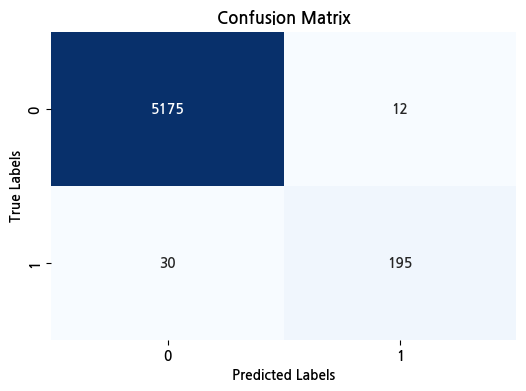

F1 Score: 0.9028
accuracy_score: 0.9922
precision_score: 0.9420
recall_score: 0.8667


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# 혼동 행렬 계산

## FTT 모델일때 inference
if params.model_name == 'FTT' :
    test_data = FttDataloader(test)
    test_loader = DataLoader(test_data, batch_size=len(test), shuffle=False)

    model.to(device)
    model.eval()
    all_pred = []
    all_y = []
    x_samples = []
    with torch.no_grad():
        cul_loss = 0  # SE
        count = 0
        for batch, (x_categ, x_numer, y) in enumerate(test_loader):
            x_categ, x_numer, y = x_categ.to(device), x_numer.to(device), y.to(device)
            # 예측 오류 계산
            pred = model(x_categ, x_numer)
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            all_pred.extend(pred)
            all_y.extend(y)

    all_pred = np.array(all_pred)
    all_y = np.array(all_y)

    y_test = pd.DataFrame(np.array(all_y)) 
    y_pred = pd.DataFrame(np.array(all_pred)).round(1).astype(int)
## 그외 모델일때
else :

    X_test, y_test = test[columns.input_columns], test[columns.target_column]
    

    y_pred = model.predict(X_test.values)
    test_cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 계산
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 점수 계산
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

acc = accuracy_score(y_test, y_pred)
print(f'accuracy_score: {acc:.4f}')

ps = precision_score(y_test, y_pred)
print(f'precision_score: {ps:.4f}')

rs = recall_score(y_test, y_pred)
print(f'recall_score: {rs:.4f}')


# Postprocessing

## 유민님 작업 공간

# Prescriptor

In [102]:
import numpy as np
from ipypb import ipb

## 기준이 되는 값을 평균으로 정함
## Context가 들어오면 Action초기 값은 평균으로 대체되고, 그 이후에 최적의 조합을 찾음
lower_mold_temp2_init = test['lower_mold_temp2'].mean()
cast_pressure_init = test['cast_pressure'].mean()
molten_temp_init = test['molten_temp'].mean()

context = test[columns.context_columns]

def input_context(context):
    ## 최적화 하고 싶은 context를 데이터 프레임 형태로 입력

    df = context
    df['lower_mold_temp2'] = lower_mold_temp2_init
    df['cast_pressure'] = cast_pressure_init
    df['molten_temp'] = molten_temp_init

    return df

def objective_function(solution):
    
    X_input = df[columns.input_columns].copy()
    X_input['lower_mold_temp2'] += solution
    X_input['cast_pressure'] += solution
    X_input['molten_temp'] += solution

    return model.predict(X_input).mean()

def init_function(X_test) :
    return model.predict(X_test).mean()

## 컨텍스트 입력 
## TODO : class화 해서 self로 받을 것
df = input_context(context)
X_test = df[columns.input_columns]

def simulated_annealing(initial_temp, cooling_rate, max_iterations):

    current_solution = np.random.randint(-3, 3, len(X_test))  # 초기 해
    current_energy = objective_function(current_solution)

    init_solution = current_solution
    init_energy  = init_function(X_test)

    best_solution = current_solution
    best_energy = init_function(X_test)
    
    temp = initial_temp

    for _ in ipb(range(max_iterations)):
        # 온도에 비례하여 탐색 범위를 줄이기 위한 인자 설정
        neighbor_range = temp / initial_temp * 20
        new_solution = current_solution + np.random.normal(-neighbor_range, neighbor_range, len(X_test))
        new_energy = objective_function(new_solution)

        if neighbor_range < 0.5:
            print(neighbor_range)
            break

        
        # 결과 출력 (에너지 변화 추적)
        # print(f"Iteration {iteration}: Current Energy: {current_energy}, New Energy: {new_energy}")
        # print(best_energy)

        # 에너지 변화 조건에 따라 새로운 해 수용
        if new_energy < current_energy:
            current_solution = new_solution
            current_energy = new_energy

            if current_energy < best_energy:
                print('best_energy 갱신')
                best_solution = current_solution
                best_energy = current_energy

        # 온도 감소
        temp *= cooling_rate

    return init_solution, init_energy, best_solution, best_energy

# 파라미터 설정
initial_temperature = 1000
cooling_rate = 0.999
max_iterations = 10000

# Simulated Annealing 실행
init_solution, init_energy, best_solution, best_energy = simulated_annealing(
    initial_temperature, cooling_rate, max_iterations)

print(f"초기해: {init_solution}, 초기 에너지: {init_energy}")
print(f"최적해: {best_solution}, 최적 에너지: {best_energy}")


 [██████████████████████######################################] 3679/10000 [00:34<00:00, 0.01s/it]

best_energy 갱신
0.49951734503477174
초기해: [ 0 -1 -2 ...  1  0 -3], 초기 에너지: 0.020140428677014044
최적해: [-0.8050517  -2.78817139 -2.54640849 ...  0.81764414 -1.13569512
 -2.23764578], 최적 에너지: 0.01977087952697709


In [103]:
## 최적화 결과 비교

X_test_origin, y_test = test[columns.input_columns], test[columns.target_column]
X_test = X_test_origin.copy()

X_test['lower_mold_temp2'] += best_solution
X_test['cast_pressure'] += best_solution
X_test['molten_temp'] += best_solution

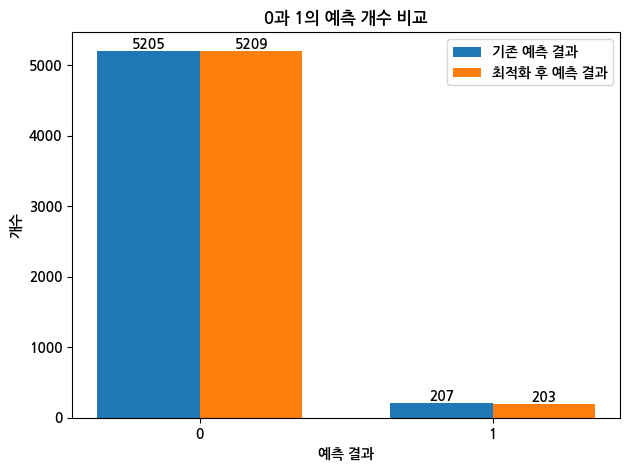

In [105]:
# 예측 결과 생성
pred_origin = model.predict(X_test_origin)  # 기존 예측 결과
pred_test = model.predict(X_test)  # 새로운 예측 결과

# 각 예측 결과에서 0과 1의 개수 계산
count_origin = [np.sum(pred_origin == 0), np.sum(pred_origin == 1)]
count_test = [np.sum(pred_test == 0), np.sum(pred_test == 1)]

# 막대 그래프 데이터 준비
labels = ['0', '1']
x = np.arange(len(labels))  # x축 위치

# 그래프 그리기
width = 0.35  # 막대 너비

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, count_origin, width, label='기존 예측 결과')
bars2 = ax.bar(x + width/2, count_test, width, label='최적화 후 예측 결과')

# 라벨 추가
ax.set_xlabel('예측 결과')
ax.set_ylabel('개수')
ax.set_title('0과 1의 예측 개수 비교')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 각 막대에 값 표시
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()
